***MMA823 Assignment 2***

Jose Chua  
20069208  
Febuary 14th, 2025  

***Part 1: Historical Data and Stock Betas Analysis (12 points)***

In [1]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

# Define stock tickers
tickers = ["RACE", "TSLA", "JNJ", "XOM", "^GSPC"]

# Fetch weekly adjusted closing prices from Yahoo Finance
start_date = "2015-01-02"
end_date = "2025-01-02"  # 10-year window

data = yf.download(tickers, start=start_date, end=end_date, interval="1wk")["Close"]

# Fetch risk-free rate from FRED (US 3-Month Treasury Rate)
rf = pdr.get_data_fred("DTB3", start=start_date, end=end_date)

# Convert annualized risk-free rate to weekly
rf["Weekly Rate"] = rf["DTB3"] / 52 / 100

# Calculate weekly returns
returns = data.pct_change().dropna()

# Merge risk-free rate
returns = returns.join(rf["Weekly Rate"]).dropna()

returns.head()

[*********************100%***********************]  5 of 5 completed


,JNJ,RACE,TSLA,XOM,^GSPC,Weekly Rate
Date,,,,,,
2015-10-22,0.029191,0.000000,0.013661,0.025807,0.035370,0.000000
2015-10-26,0.000000,-0.105534,0.000000,0.000000,0.000000,0.000004
2015-10-29,0.014531,0.000000,0.087669,0.044969,0.005722,0.000013
2015-11-02,0.000000,0.039659,0.000000,0.000000,0.000000,0.000015
2015-11-05,-0.000785,0.000000,-0.054181,-0.050710,-0.012990,0.000010


In [2]:
#beta estimation
import statsmodels.api as sm

betas = {}

for stock in tickers[:-1]:  # Exclude market index (^GSPC)
    X = returns["^GSPC"] - returns["Weekly Rate"]  # Market excess return
    y = returns[stock] - returns["Weekly Rate"]  # Stock excess return

    X = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y, X).fit()
    
    betas[stock] = model.params  # Store alpha and beta
    
    print(f"\n{stock} Regression Results:")
    print(model.summary())


RACE Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.04635
Date:                Fri, 14 Feb 2025   Prob (F-statistic):              0.830
Time:                        17:06:17   Log-Likelihood:                 1931.8
No. Observations:                 886   AIC:                            -3860.
Df Residuals:                     884   BIC:                            -3850.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020     

c:\Users\Jose Chua\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
c:\Users\Jose Chua\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
c:\Users\Jose Chua\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
c:\Users\Jose Chua\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Tesla (TSLA) has the highest beta of ~1.99, meaning it is the most sensitive to market movements. A beta of nearly 2 suggests that Tesla's stock price tends to move almost twice as much as the S&P 500. If the market increases by 1%, Tesla is expected to increase by approximately 1.99%, and vice versa.

ExxonMobil (XOM) has a beta of ~0.96, indicating that it moves almost in line with the market. A beta near 1 means ExxonMobil has a market-like risk profile.

Johnson & Johnson (JNJ) has a beta of ~0.39, suggesting that it is less sensitive to market movements. This lower beta implies JNJ is more stable and defensive, likely due to its presence in the healthcare sector.

Ferrari (RACE) has a beta close to ~-0.012, which is near zero and even slightly negative. This suggests that Ferrari's stock is largely uncorrelated with market movements. A beta near zero means that the stock's returns are not significantly impacted by the overall market.

Conclusion:
- Most sensitive to market changes: Tesla (TSLA) with a beta of 1.99, meaning it moves nearly twice as much as the overall market.
- Least sensitive to market changes: Ferrari (RACE) with a beta close to zero, indicating little to no correlation with market movements.
- Defensive stock: Johnson & Johnson (JNJ) with a beta of 0.39, making it a more stable investment, especially during market downturns.
- Market-neutral stock: ExxonMobil (XOM) with a beta of 0.96, meaning it generally tracks the market’s movements.
Tesla is highly volatile and reacts strongly to market swings, making it a riskier investment. On the other hand, Ferrari’s near-zero beta suggests its stock price is largely unaffected by market trends, which is unusual for a publicly traded company.

In [3]:
beta_value = model.params.iloc[-1]  # Always select the last coefficient

c:\Users\Jose Chua\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


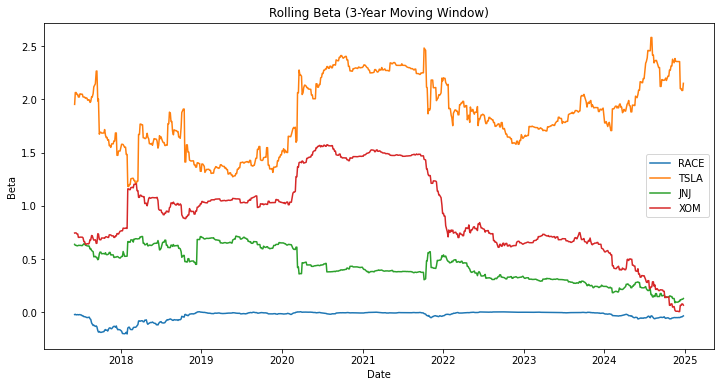

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

window_size = 157  # 3 years of weekly data
rolling_betas = {stock: [] for stock in tickers[:-1]}  # Store beta values
dates = []

for i in range(len(returns) - window_size):
    window_data = returns.iloc[i : i + window_size]

    X = window_data["^GSPC"] - window_data["Weekly Rate"]
    if X.std() == 0:  
        continue  # Skip if no variance in market returns
    
    X = sm.add_constant(X)  # Add intercept
    
    for stock in tickers[:-1]:  # Exclude the market index
        y = window_data[stock] - window_data["Weekly Rate"]
        
        if y.std() == 0:  # Skip if no variation in stock returns
            rolling_betas[stock].append(np.nan)
            continue
        
        model = sm.OLS(y, X).fit()
        
        # FIX: Ensure correct indexing
        beta_value = model.params.iloc[-1]  # Get last parameter (beta)
        
        rolling_betas[stock].append(beta_value)

    dates.append(window_data.index[-1])

# Convert to DataFrame
rolling_betas_df = pd.DataFrame(rolling_betas, index=dates)

# Plot Rolling Beta Graph
plt.figure(figsize=(12,6))
for stock in rolling_betas_df.columns:
    plt.plot(rolling_betas_df.index, rolling_betas_df[stock], label=stock)

plt.xlabel("Date")
plt.ylabel("Beta")
plt.title("Rolling Beta (3-Year Moving Window)")
plt.legend()
plt.show()

***Part 2: Logit Regression for Credit Default (10 pts)***

In [5]:
df= pd.read_excel(r'C:\Users\Jose Chua\OneDrive\Python\School Snek Work\Project_Work\823_analytics_for_financial_markets\Credit Card Data.xlsx')

# Display the first few rows to understand the structure
df.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


Summary Statistics:
                 ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

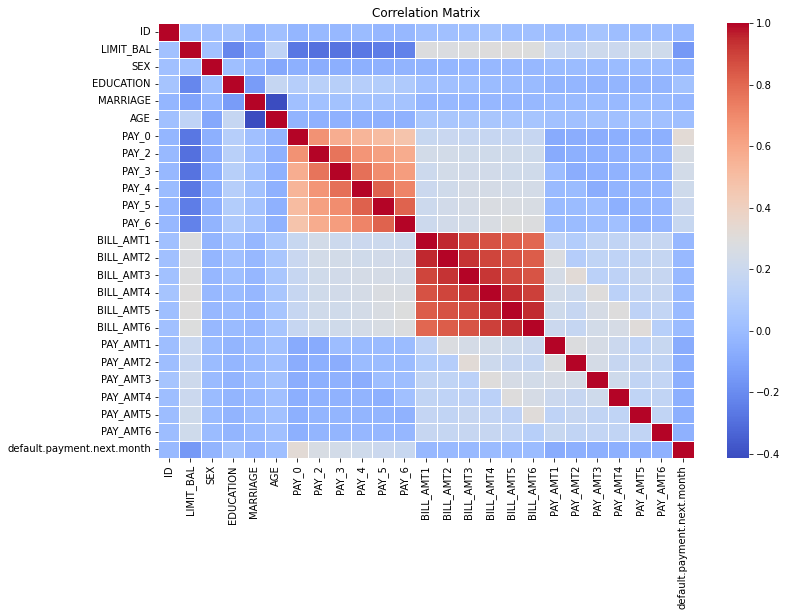

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistics
summary_stats = df.describe()

# Check for missing values
missing_values = df.isnull().sum()

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Matrix")

# Display results
print("Summary Statistics:")
print(summary_stats)

missing_values

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Drop ID column as it's not useful for modeling
df = df.drop(columns=['ID'])

# Define categorical and numerical columns
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
numerical_cols = [col for col in df.columns if col not in categorical_cols + ['default.payment.next.month']]

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# Define logistic regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(max_iter=1000))])

# Define train-test split (first 20000 for training, next 10000 for testing)
train_data = df.iloc[:20000]
test_data = df.iloc[20000:30000]

X_train = train_data.drop(columns=['default.payment.next.month'])
y_train = train_data['default.payment.next.month']

X_test = test_data.drop(columns=['default.payment.next.month'])
y_test = test_data['default.payment.next.month']

# Train the model
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

# Display accuracy and classification report
accuracy, report


(0.8207,
 {'0': {'precision': 0.8263230752848472,
   'recall': 0.979550618530674,
   'f1-score': 0.8964362040085485,
   'support': 7922.0},
  '1': {'precision': 0.7339901477832512,
   'recall': 0.2151106833493744,
   'f1-score': 0.3327130628954224,
   'support': 2078.0},
  'accuracy': 0.8207,
  'macro avg': {'precision': 0.7801566115340492,
   'recall': 0.5973306509400242,
   'f1-score': 0.6145746334519855,
   'support': 10000.0},
  'weighted avg': {'precision': 0.8071362929500155,
   'recall': 0.8207,
   'f1-score': 0.779294535285241,
   'support': 10000.0}})

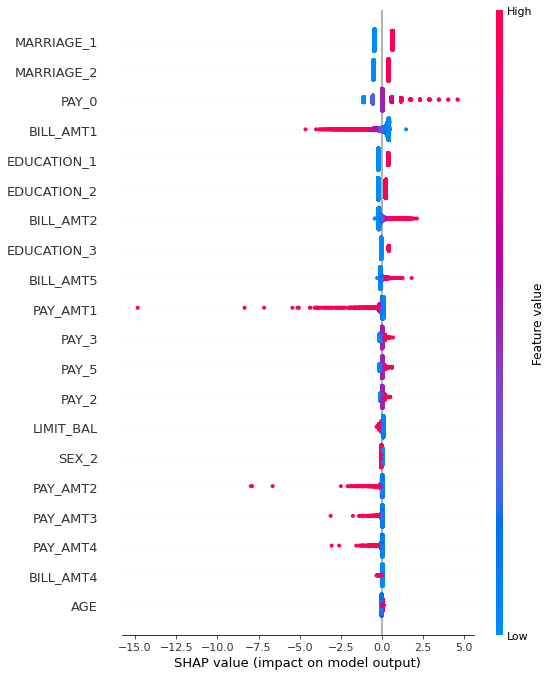

In [8]:
import shap

# Get transformed dataset
X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)

# Extract feature names after preprocessing
feature_names = numerical_cols + list(
    model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
)

# Convert to DataFrame for compatibility
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Compute SHAP values
explainer = shap.Explainer(model.named_steps['classifier'], X_test_transformed_df)
shap_values = explainer(X_test_transformed_df)

# Summary plot for feature importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_transformed_df)


Feature Importance:
        Feature  Importance
27   MARRIAGE_1    1.104766
29   MARRIAGE_3    0.955096
28   MARRIAGE_2    0.903691
24  EDUCATION_4    0.831921
2         PAY_0    0.640723
21  EDUCATION_1    0.592267
25  EDUCATION_5    0.588344
26  EDUCATION_6    0.510187
8     BILL_AMT1    0.484312
23  EDUCATION_3    0.473823
22  EDUCATION_2    0.465718
14     PAY_AMT1    0.260392
9     BILL_AMT2    0.239892
15     PAY_AMT2    0.140341
12    BILL_AMT5    0.137330
4         PAY_3    0.099379
6         PAY_5    0.094882
20        SEX_2    0.091241
3         PAY_2    0.082751
17     PAY_AMT4    0.075348
0     LIMIT_BAL    0.068040
16     PAY_AMT3    0.056181
19     PAY_AMT6    0.040493
11    BILL_AMT4    0.031670
1           AGE    0.021739
13    BILL_AMT6    0.015494
5         PAY_4    0.013695
18     PAY_AMT5    0.012263
10    BILL_AMT3    0.010759
7         PAY_6    0.010210


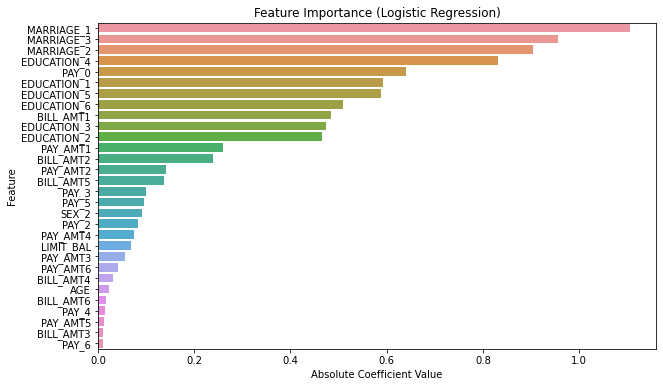

In [10]:
import numpy as np

# Extract feature names after preprocessing
feature_names = numerical_cols + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols))

# Get model coefficients
coefficients = model.named_steps['classifier'].coef_[0]

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Print feature importance
print("Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Logistic Regression)')
plt.show()


In [13]:
# Define new train-test split (last 20000 rows for training, first 10000 for testing)
train_data_alt = df.iloc[-20000:]
test_data_alt = df.iloc[:10000]

X_train_alt = train_data_alt.drop(columns=['default.payment.next.month'])
y_train_alt = train_data_alt['default.payment.next.month']

X_test_alt = test_data_alt.drop(columns=['default.payment.next.month'])
y_test_alt = test_data_alt['default.payment.next.month']

# Train the model with the new train-test split
model.fit(X_train_alt, y_train_alt)

# Predictions and evaluation
y_pred_alt = model.predict(X_test_alt)
accuracy_alt = accuracy_score(y_test_alt, y_pred_alt)
report_alt = classification_report(y_test_alt, y_pred_alt, output_dict=True)

# Display new accuracy and classification report
accuracy_alt, report_alt

(0.8025,
 {'0': {'precision': 0.8135058721183123,
   'recall': 0.9664126081901563,
   'f1-score': 0.8833913916277971,
   'support': 7741.0},
  '1': {'precision': 0.6766169154228856,
   'recall': 0.24081451969898185,
   'f1-score': 0.35520731309174014,
   'support': 2259.0},
  'accuracy': 0.8025,
  'macro avg': {'precision': 0.745061393770599,
   'recall': 0.6036135639445691,
   'f1-score': 0.6192993523597686,
   'support': 10000.0},
  'weighted avg': {'precision': 0.7825826568008154,
   'recall': 0.8025,
   'f1-score': 0.7640746082865019,
   'support': 10000.0}})

After rerunning the model with a different train-test split (training on the last 20,000 rows and testing on the first 10,000), the accuracy dropped slightly from 0.8207 to 0.8025. The recall for class 0 decreased from 0.9795 to 0.9664, while class 1 saw a slight improvement from 0.2115 to 0.2408. The weighted F1-score also declined from 0.7793 to 0.7640, indicating a small drop in overall performance. This suggests that the distribution of the data over time might be affecting model generalization, as training on the most recent data and testing on older data introduced slight inconsistencies.

***Part 3. Yield curve data (8 points)***

In [15]:
ydf = pd.read_csv(r'C:\Users\Jose Chua\OneDrive\Python\School Snek Work\Project_Work\823_analytics_for_financial_markets\yield_curves (1).csv')

In [24]:
ydf.tail(10)

,Date,ZC025YR,ZC050YR,ZC075YR,ZC100YR,ZC125YR,ZC150YR,ZC175YR,ZC200YR,ZC225YR,...,ZC2775YR,ZC2800YR,ZC2825YR,ZC2850YR,ZC2875YR,ZC2900YR,ZC2925YR,ZC2950YR,ZC2975YR,ZC3000YR
2578,2024-12-18,0.031319,0.031144,0.030769,0.030480,0.030626,0.030388,0.030184,0.030017,0.029886,...,0.032586,0.032578,0.032569,0.032557,0.032544,0.032530,0.032514,0.032496,0.032477,0.032456
2579,2024-12-19,0.031296,0.031300,0.031010,0.030776,0.030807,0.030613,0.030453,0.030331,0.030246,...,0.033859,0.033851,0.033842,0.033832,0.033819,0.033806,0.033790,0.033773,0.033754,0.033734
2580,2024-12-20,0.031305,0.031219,0.030909,0.030638,0.030536,0.030309,0.030116,0.029961,0.029843,...,0.033442,0.033434,0.033424,0.033413,0.033400,0.033386,0.033370,0.033352,0.033333,0.033313
2581,2024-12-23,0.031358,0.031225,0.030901,0.030596,0.030357,0.030121,0.029926,0.029772,0.029661,...,0.033648,0.033640,0.033629,0.033617,0.033604,0.033588,0.033571,0.033553,0.033533,0.033512
2582,2024-12-24,0.031401,0.031172,0.030854,0.030559,0.030337,0.030100,0.029909,0.029763,0.029661,...,0.033812,0.033804,0.033793,0.033781,0.033768,0.033753,0.033736,0.033718,0.033698,0.033677
2583,2024-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2584,2024-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2585,2024-12-27,0.031355,0.030951,0.030516,0.030172,0.030088,0.029863,0.029682,0.029545,0.029450,...,0.034120,0.034109,0.034097,0.034083,0.034067,0.034050,0.034032,0.034012,0.033990,0.033967
2586,2024-12-30,0.031388,0.030820,0.030392,0.030000,0.029692,0.029438,0.029236,0.029080,0.028970,...,0.033553,0.033540,0.033525,0.033508,0.033490,0.033471,0.033450,0.033428,0.033405,0.033379
2587,2024-12-31,0.031425,0.030694,0.030169,0.029699,0.029355,0.029044,0.028812,0.028650,0.028548,...,0.033258,0.033253,0.033248,0.033242,0.033235,0.033228,0.033220,0.033211,0.033202,0.033192


In [33]:
from sklearn.decomposition import PCA

In [18]:
# Convert Date column to datetime
ydf["Date"] = pd.to_datetime(ydf["Date"])

In [21]:
# Trim whitespace from column names
ydf.columns = ydf.columns.str.strip()
ydf = ydf.loc[:, ydf.columns != ""]

In [22]:
# Convert yield data to numeric values
ydf.iloc[:, 1:] = ydf.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

-	Show a simple chart of the most recent yield curve (latest date point in the data file) and the yield curve by the end of 2023-Dec. How did the interest rates change since then? Compare the values with yields you see now. 

In [23]:
# Extract the latest date and the end of 2023 data
latest_date = ydf["Date"].max()
end_2023_date = pd.Timestamp("2023-12-29")

In [25]:
latest_yields = ydf[ydf["Date"] == latest_date].iloc[:, 1:].values.flatten()
end_2023_yields = ydf[ydf["Date"] == end_2023_date].iloc[:, 1:].values.flatten()

In [26]:
latest_yields = ydf[ydf["Date"] == latest_date].iloc[:, 1:].values.flatten()
end_2023_yields = ydf[ydf["Date"] == end_2023_date].iloc[:, 1:].values.flatten()

In [28]:
# Extract maturities from column names (remove "ZC" and convert to years)
maturities = [int(col.replace("ZC", "").replace("YR", "")) / 100 for col in ydf.columns[1:]]

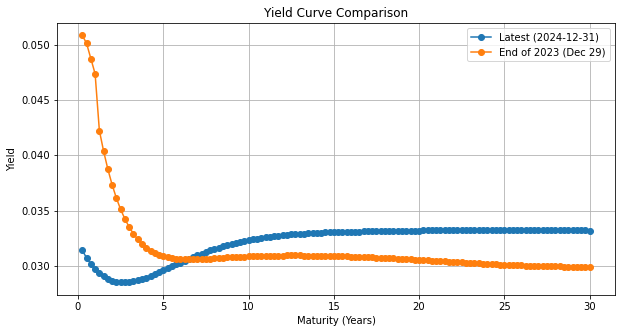

In [29]:
# Plot yield curves
plt.figure(figsize=(10, 5))
plt.plot(maturities, latest_yields, marker='o', label=f'Latest ({latest_date.date()})')
plt.plot(maturities, end_2023_yields, marker='o', label='End of 2023 (Dec 29)')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.title("Yield Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

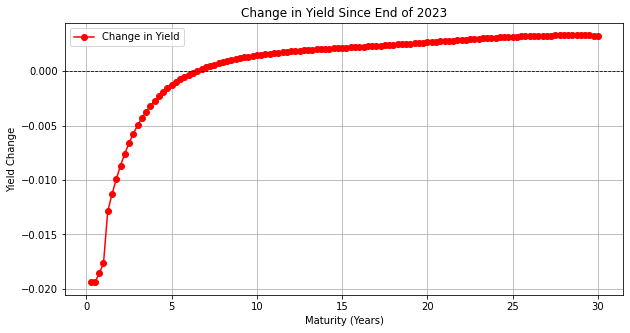

In [30]:
# Compute the difference in yields
yield_changes = latest_yields - end_2023_yields

# Plot change in yields
plt.figure(figsize=(10, 5))
plt.plot(maturities, yield_changes, marker='o', color='r', label='Change in Yield')
plt.axhline(0, linestyle='--', color='black', linewidth=0.8)
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield Change")
plt.title("Change in Yield Since End of 2023")
plt.legend()
plt.grid(True)
plt.show()

Since the end of 2023, interest rates have generally increased, particularly for short-term maturities. The most recent yield curve shows a noticeable rise in yields compared to December 2023, with short-term rates (0-5 years) experiencing the most significant jump, while longer-term rates have increased more moderately. This shift has resulted in a yield curve that is now more upward-sloping, indicating that the market is pricing in continued central bank policy tightening or expectations of persistent inflation. The largest increase is seen in short-term rates, which have risen by nearly 20 basis points (0.20%) or more, suggesting concerns about inflation and potential rate hikes. Meanwhile, long-term rates have increased only slightly, implying that investors do not anticipate significant long-term inflationary pressures. As a result, the yield spread between short- and long-term maturities has narrowed. This trend suggests that while the market expects tighter monetary policy in the near term, there is also an expectation of future economic stabilization or even a decline in policy rates.

***PCA Analysis***

In [35]:
# Run PCA Analysis
yield_data = ydf.iloc[:, 1:].dropna().values  # Drop NaN values
pca = PCA()
pca.fit(yield_data)

PCA()

In [36]:
# Extract the first two principal components
pca_data = pca.transform(yield_data)[:, :2]
valid_dates = ydf["Date"][ydf.iloc[:, 1:].dropna().index]

In [37]:
# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)
num_components_99 = np.argmax(explained_variance >= 0.99) + 1

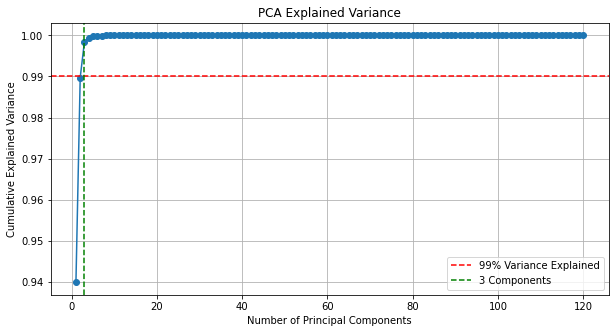

In [38]:
# Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(0.99, linestyle="--", color="r", label="99% Variance Explained")
plt.axvline(num_components_99, linestyle="--", color="g", label=f"{num_components_99} Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Extract the first two principal components
pca_data = pca.transform(yield_data)[:, :2]
valid_dates = ydf["Date"][ydf.iloc[:, 1:].dropna().index]

In [41]:
# Print number of components explaining 99% variance
print(f"Number of principal components explaining 99% variance: {num_components_99}")

Number of principal components explaining 99% variance: 3


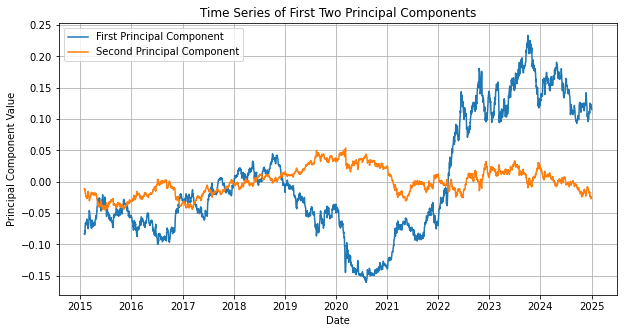

In [40]:
# Plot time series of first two PCAs
plt.figure(figsize=(10, 5))
plt.plot(valid_dates, pca_data[:, 0], label="First Principal Component")
plt.plot(valid_dates, pca_data[:, 1], label="Second Principal Component")
plt.xlabel("Date")
plt.ylabel("Principal Component Value")
plt.title("Time Series of First Two Principal Components")
plt.legend()
plt.grid(True)
plt.show()